### Look at multi-preference selectivity, see if that is a rare occasion, or frequency predicted from random sampling
https://www.notion.so/walkerlab/Are-preference-selective-units-sparse-No-1ce2dc9f99928066a5cbc96120ad6444


In [4]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [-1000, 0]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_stim_res = io_utils.read_anova_good_units(args, "95th")
good_pref_stim_res["session"] = (good_pref_stim_res.PseudoUnitID / 100).astype(int)


In [7]:
units_to_num_feats = good_pref_stim_res.groupby("PseudoUnitID").feat.nunique().reset_index(name="num_feats")
multi = units_to_num_feats[units_to_num_feats.num_feats > 1]
len(multi)

63

In [8]:
good_pref_stim_res

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,combined_fracvar,feat,95th,99th,drive,structure_level2,session
0,2018070915,2.422364,0.053620,0.015361,0.002913,0.928106,1.0,0.018274,CIRCLE,0.016087,0.017649,Anterior,orbital_frontal_cortex (OFC),20180709
1,2018070923,1.776541,0.018866,0.012020,0.006379,0.962735,1.0,0.018399,CIRCLE,0.017245,0.020738,Anterior,anterior_cingulate_gyrus (ACgG),20180709
2,2018070924,0.378612,0.005910,0.006983,0.009002,0.978105,1.0,0.015985,CIRCLE,0.013639,0.016854,Temporal,inferior_temporal_cortex (ITC),20180709
3,2018070939,69.875670,0.032653,0.020282,0.001109,0.945956,1.0,0.021391,CIRCLE,0.017570,0.026021,Anterior,motor_cortex (motor),20180709
4,2018091811,41.695163,0.101644,0.013591,0.006587,0.878178,1.0,0.020178,CIRCLE,0.017850,0.020574,Temporal,inferior_temporal_cortex (ITC),20180918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,2018061509,73.198318,0.150947,0.045414,0.004032,0.799607,1.0,0.049446,SWIRL,0.034441,0.046667,Temporal,inferior_parietal_lobule (IPL),20180615
420,2018061514,33.623868,0.003252,0.035734,0.003283,0.957731,1.0,0.039017,SWIRL,0.025101,0.066352,Temporal,core_and_belt_areas_of_auditory_cortex (core/b...,20180615
421,2018061516,7.606001,0.025269,0.036052,0.004187,0.934492,1.0,0.040239,SWIRL,0.029989,0.047919,Anterior,lateral_prefrontal_cortex (lat_PFC),20180615
422,2018061531,5.681280,0.007831,0.015840,0.004889,0.971439,1.0,0.020729,SWIRL,0.019493,0.023835,Anterior,lateral_prefrontal_cortex (lat_PFC),20180615


In [9]:
units_by_feat_sess = good_pref_stim_res.groupby(["session", "feat"]).PseudoUnitID.nunique().reset_index(name="num_units")
units = pd.read_pickle(UNITS_PATH.format(sub="SA"))
rng = np.random.default_rng()

In [10]:
units_by_feat_sess

,session,feat,num_units
0,20180615,CIRCLE,6
1,20180615,RIPPLE,5
2,20180615,SQUARE,3
3,20180615,SWIRL,8
4,20180615,TRIANGLE,3
...,...,...,...
170,20181010,CIRCLE,2
171,20181010,ESCHER,5
172,20181010,RIPPLE,1
173,20181010,YELLOW,1


In [11]:
shuf_num_multis = []
for i in tqdm(range(1000)):
    shuffle_res = []
    for idx, row in units_by_feat_sess.iterrows():
        sess_units = units[units.session == str(row.session)].PseudoUnitID.values
        chosen_units = rng.choice(sess_units, row.num_units, replace=False)
        shuffle_res.append(pd.DataFrame({"PseudoUnitID": chosen_units, "session": row.session, "feat": row.feat}))
    shuffle_res = pd.concat(shuffle_res)
    shuff_units_to_num_feats = shuffle_res.groupby("PseudoUnitID").feat.nunique().reset_index(name="num_feats")
    shuff_num_multi = len(shuff_units_to_num_feats[shuff_units_to_num_feats.num_feats > 1])
    shuf_num_multis.append(shuff_num_multi)


100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


In [12]:
shuf_num_multis = pd.DataFrame({"num_multi": shuf_num_multis})

<Axes: xlabel='num_multi', ylabel='Count'>

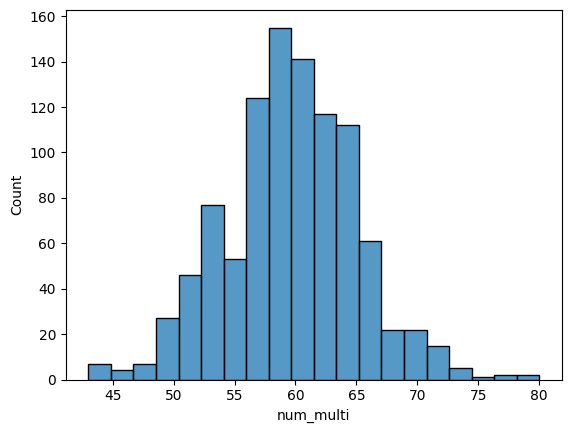

In [16]:
sns.histplot(shuf_num_multis, x="num_multi", bins=20)